These are useful imports for training the model.

In [332]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

In [333]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

gpus

[]

Making sure that the directories with the data are all present.

In [334]:
letters = os.listdir("letters")

for letter in letters:
    print(f"{letter}: {len(os.listdir(f'letters/{letter}'))}")


a: 300
b: 300
c: 300
d: 300
e: 300
f: 300
g: 300
h: 300
i: 300
k: 300
l: 300
m: 300
n: 300
o: 300
p: 300
q: 300
r: 300
s: 300
t: 300
u: 300
v: 300
w: 300
x: 300
y: 300


In [335]:
file_names = os.listdir("letters/a")


file_names

['a_0.parquet',
 'a_1.parquet',
 'a_10.parquet',
 'a_100.parquet',
 'a_101.parquet',
 'a_102.parquet',
 'a_103.parquet',
 'a_104.parquet',
 'a_105.parquet',
 'a_106.parquet',
 'a_107.parquet',
 'a_108.parquet',
 'a_109.parquet',
 'a_11.parquet',
 'a_110.parquet',
 'a_111.parquet',
 'a_112.parquet',
 'a_113.parquet',
 'a_114.parquet',
 'a_115.parquet',
 'a_116.parquet',
 'a_117.parquet',
 'a_118.parquet',
 'a_119.parquet',
 'a_12.parquet',
 'a_120.parquet',
 'a_121.parquet',
 'a_122.parquet',
 'a_123.parquet',
 'a_124.parquet',
 'a_125.parquet',
 'a_126.parquet',
 'a_127.parquet',
 'a_128.parquet',
 'a_129.parquet',
 'a_13.parquet',
 'a_130.parquet',
 'a_131.parquet',
 'a_132.parquet',
 'a_133.parquet',
 'a_134.parquet',
 'a_135.parquet',
 'a_136.parquet',
 'a_137.parquet',
 'a_138.parquet',
 'a_139.parquet',
 'a_14.parquet',
 'a_140.parquet',
 'a_141.parquet',
 'a_142.parquet',
 'a_143.parquet',
 'a_144.parquet',
 'a_145.parquet',
 'a_146.parquet',
 'a_147.parquet',
 'a_148.parquet',
 

Converting the parquet files to dataframes and doing some preprocessing by removing the pose and face data and the row_id column. Only the hand data is kept. NaN values are converted to -1. The sign column is added to the dataframe. The type column is encoded to 0 or 1 for left and right hand respectively. The frame column is normalized to start at 0 and the dataframe is limited to 100 frames.

In [336]:
dataframes = []

for letter in letters:
    num_of_files = min(300, len(os.listdir(f'letters/{letter}')))
    for file in range(num_of_files):
        df = pd.read_parquet(f'letters/{letter}/{letter}_{file}.parquet')
        df.fillna(0, inplace=True)
        df["sign"] = letters.index(letter)
        dataframes.append(df)

dataframes[0]

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,sign
Right,0.726712,0.74308,0.670479,0.726974,0.616503,0.657779,0.588644,0.589678,0.591568,0.533896,...,0.622846,0.753058,0.559566,0.741546,0.570722,0.737008,0.618766,0.740743,0.616024,0


A peek at the distribution of frames per dataframe can tell me if I need to pad or cut off the frames.

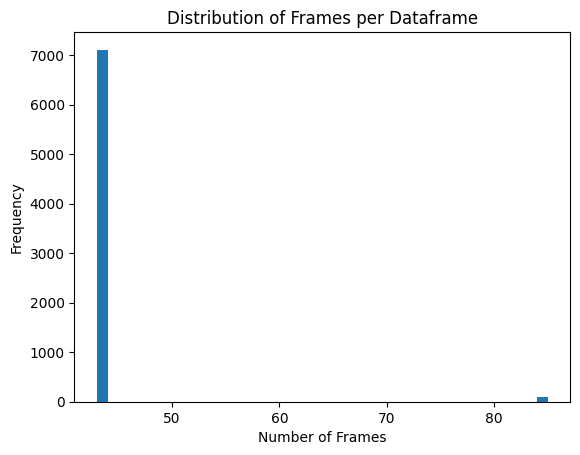

In [337]:
import matplotlib.pyplot as plt

# Get distribution of frames per dataframe
frame_counts = [df.shape[1] for df in dataframes]

# Graph distribution
plt.hist(frame_counts, bins=range(min(frame_counts), max(frame_counts) + 1))
plt.xlabel("Number of Frames")
plt.ylabel("Frequency")
plt.title("Distribution of Frames per Dataframe")
plt.show()


Padding will be done up to the 40th frame. All frames past 40 (#39 since they are zero-indexed) will be removed.

In [338]:
final_max_length = max([df.shape[1] for df in dataframes])
final_min_length = min([df.shape[1] for df in dataframes])

final_max_length, final_min_length

(85, 43)

In [339]:
dataframes = [df for df in dataframes if df.shape[1] == 43]


In [340]:
final_max_length = max([df.shape[1] for df in dataframes])
final_min_length = min([df.shape[1] for df in dataframes])

final_max_length, final_min_length

(43, 43)

In [341]:
dataframes

[              0        1         2         3         4         5         6  \
 Right  0.726712  0.74308  0.670479  0.726974  0.616503  0.657779  0.588644   
 
               7         8         9  ...        33        34        35  \
 Right  0.589678  0.591568  0.533896  ...  0.622846  0.753058  0.559566   
 
              36        37        38        39        40        41  sign  
 Right  0.741546  0.570722  0.737008  0.618766  0.740743  0.616024     0  
 
 [1 rows x 43 columns],
               0         1         2         3         4         5         6  \
 Right  0.717716  0.747245  0.663165  0.733379  0.609049  0.663454  0.580759   
 
               7         8         9  ...        33        34        35  \
 Right  0.594424  0.583677  0.538552  ...  0.622441  0.745638  0.561972   
 
             36        37        38       39        40        41  sign  
 Right  0.73464  0.568163  0.731049  0.61583  0.733866  0.613247     0  
 
 [1 rows x 43 columns],
               0         1

This flattens the dataframes into a 2D array of features where each row is the frame info consisting of the x, y, and z coordinates of the 42 landmarks.

In [342]:
# Extract X and y
X = [df.iloc[:, :-1].to_numpy().flatten() for df in dataframes]  # Features (all columns except the last)
y = [df.iloc[:, -1].item() for df in dataframes]  # Labels (last column)

# Convert to NumPy arrays for machine learning tasks
X = np.array(X)
y = np.array(y)

X.shape, y.shape


((7106, 42), (7106,))

This is the basic model being used. It is a simple LSTM with a dense layer for classification.

In [343]:

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1], )),
    Dense(len(letters), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Or 'categorical_crossentropy' for one-hot labels
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 128)               5504      
                                                                 
 dense_57 (Dense)            (None, 24)                3096      
                                                                 
Total params: 8600 (33.59 KB)
Trainable params: 8600 (33.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Creating the training and validation data.

In [344]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=602, shuffle=True)


Training.

In [345]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=8)

Epoch 1/100
711/711 [==============================] - 1s 1ms/step - loss: 3.0244 - accuracy: 0.1348 - val_loss: 2.8141 - val_accuracy: 0.2145
Epoch 2/100
711/711 [==============================] - 1s 1ms/step - loss: 2.4719 - accuracy: 0.3628 - val_loss: 2.1290 - val_accuracy: 0.4810
Epoch 3/100
711/711 [==============================] - 1s 2ms/step - loss: 1.8037 - accuracy: 0.5790 - val_loss: 1.5506 - val_accuracy: 0.6287
Epoch 4/100
711/711 [==============================] - 1s 1ms/step - loss: 1.3177 - accuracy: 0.7233 - val_loss: 1.1632 - val_accuracy: 0.7257
Epoch 5/100
711/711 [==============================] - 1s 1ms/step - loss: 1.0047 - accuracy: 0.8031 - val_loss: 0.9046 - val_accuracy: 0.8601
Epoch 6/100
711/711 [==============================] - 1s 1ms/step - loss: 0.7959 - accuracy: 0.8684 - val_loss: 0.7446 - val_accuracy: 0.8537
Epoch 7/100
711/711 [==============================] - 1s 1ms/step - loss: 0.6521 - accuracy: 0.8922 - val_loss: 0.6038 - val_accuracy: 0.9093

Plotting the loss and accuracy for visualizing the model's performance.

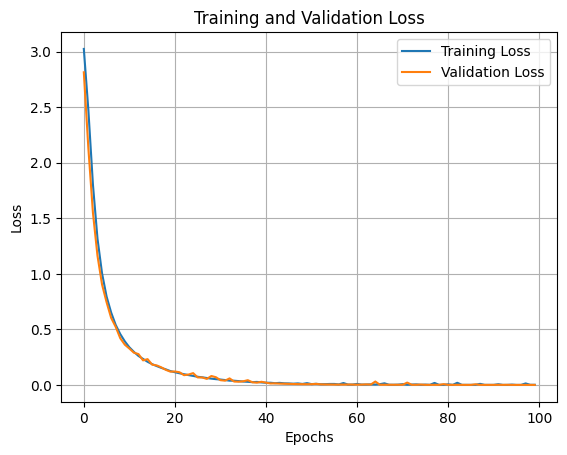

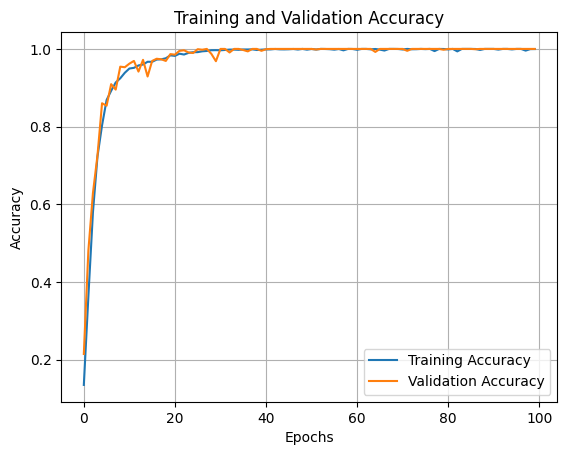

In [346]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Saving the model.

In [347]:
model.save("asl_model")

INFO:tensorflow:Assets written to: asl_model\assets


INFO:tensorflow:Assets written to: asl_model\assets
